<h2>Medical Imaging Resnet CNN Model</h2>
<h4>Authors: Sarah Brasseaux and Aaron Tegasan</h4>
<h4>Includes necessary importsa and connection to drive. To run, must have dataset files in /content/drive/Shareddrives/CSCE 704/ path.
The data is from https://www.kaggle.com/datasets/ymirsky/medical-deepfakes-lung-cancer/data</h4>

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
import pandas as pd
import multiprocessing
from scipy.ndimage import rotate
from joblib import Parallel, delayed
import itertools
import random
import torch.nn.functional as F
from datetime import datetime
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h4>Dataset Class</h4>
<h5>Parses the label to ints and opens each image in gray scale.</h5>
<p>The dataset is set up as a tuple with the image, label. The label is mapped with FB(False-Benign) to 0, TB(True-Benign) to 1, FM(False-Malicious) to 2, and TM(True-Malicious) to 3.</p>

In [46]:
class CTScanDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")]

        # Map string labels to integers
        self.label_mapping = {"FB": 0, "TB": 1, "FM": 2, "TM": 3}
        self.labels = [self.label_mapping[self._parse_label(f)] for f in self.image_paths]

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def _parse_label(self, filename):
        # Extract label like "FB" from filename
        return filename.split('_')[-1].split('.')[0]

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('L')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        if image.size(0) == 1:
            image = image.repeat(3, 1, 1)

        # Ensure label is a tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label


<h4>Loading Dataset</h4>
<p>This includes the separation of data into training, validation, and testing.</p>

In [47]:
transforms = transforms.Compose([transforms.ToTensor()])

all_train_dataset = CTScanDataset(
    image_dir='/content/drive/Shareddrives/CSCE 704/images_exp1',
    #labels_file='/content/drive/My Drive/Colab Notebooks/hw3-letters-train-labels-idx1-ubyte',
    transform=transforms
)

test_dataset = CTScanDataset(
    image_dir='/content/drive/Shareddrives/CSCE 704/images_exp2',
    #labels_file='/content/drive/My Drive/Colab Notebooks/hw3-letters-test-labels-idx1-ubyte',
    transform=transforms
)

train_size = int(0.8 * len(all_train_dataset))
val_size = len(all_train_dataset) - train_size

train_dataset, val_dataset = random_split(all_train_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=32,
                          shuffle=True)

valid_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=32,
                          shuffle=False)

<h4>Sample Images with Labels</h4>
<p>Plot 25 random images from the data.</p>

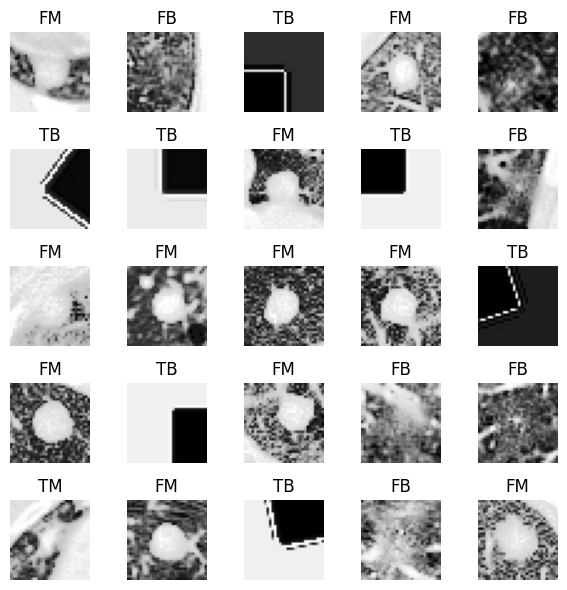

In [85]:
def decode_label(label):
    label_mapping = {0: "FB", 1: "TB", 2: "FM", 3: "TM"}
    return label_mapping[int(label)]

def show_images(dataset, num_images=25):
    fig, axes = plt.subplots(5, 5, figsize=(6, 6))
    axes = axes.flatten()

    indices = random.sample(range(len(dataset)), num_images)

    #Plot
    for i, idx in enumerate(indices):
        image, label = dataset[idx]

        image = np.transpose(image.numpy(), (1, 2, 0))
        image_squeezed = np.squeeze(image)
        axes[i].set_title(f'{decode_label(label)}')
        axes[i].imshow(image_squeezed, cmap='gray')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_images(train_dataset, num_images=25)

<h4>ResNet-18 Model Setup</h4>

In [49]:
class BuildingBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BuildingBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet18(num_classes=1000):
    return ResNet(BuildingBlock, [2, 2, 2, 2], num_classes=num_classes)

<h4>Training Loop and Helper Functions</h4>
<p>This design is based off of the training loop from hw 3.</p>

In [70]:
def initialize_resnet18(num_classes, device):
    model = resnet18(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

def get_accuracy(model, data_loader, device):
    correct_pred = 0
    n = 0

    with torch.no_grad():
        model.eval()
        for batch in data_loader:
            X, y_true = batch
            X, y_true = X.to(device), y_true.to(device)

            output = model(X)
            _, predicted_labels = torch.max(output, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum().item()

    return correct_pred / n

def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for batch in train_loader:
        X, y_true = batch

        optimizer.zero_grad()

        X = X.to(device)
        y_true = y_true.to(device)

        #forward pass
        output = model(X)
        y_hat = output[0]

        loss = criterion(output, y_true)
        running_loss += loss.item() * X.size(0)

        #back pass
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for batch in valid_loader:
        X, y_true = batch
        X, y_true = X.to(device), y_true.to(device)

        output = model(X)
        y_hat = output[0]
        loss = criterion(output, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)

    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, patience=5, print_every=1):
    #metrics
    best_loss = float('inf')
    train_losses = []
    valid_losses = []

    #process
    for epoch in range(epochs):
        #training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        #validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        #early stopping
        if valid_loss < best_loss:
            best_loss = valid_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > patience:
            print("Early stopping triggered")
            break

        if epoch % print_every == (print_every - 1):
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch + 1}/{epochs}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    return model, optimizer, (train_losses, valid_losses)

<h4>Model Training</h4>
<p>Train the model using 20 epochs and early-stopping setup.</p>

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 4

model = initialize_resnet18(num_classes=num_classes, device=device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training
trained_model, optimizer, losses = training_loop(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    valid_loader=valid_loader,
    epochs=20,
    device=device,
    patience=5
)

17:10:34 --- Epoch: 1/20	Train loss: 0.6475	Valid loss: 0.4012	Train accuracy: 87.54	Valid accuracy: 85.92
17:11:27 --- Epoch: 2/20	Train loss: 0.3317	Valid loss: 0.2188	Train accuracy: 93.30	Valid accuracy: 91.78
17:12:21 --- Epoch: 3/20	Train loss: 0.2670	Valid loss: 0.2015	Train accuracy: 96.89	Valid accuracy: 93.43
17:13:15 --- Epoch: 4/20	Train loss: 0.1924	Valid loss: 0.2165	Train accuracy: 94.24	Valid accuracy: 91.08
17:14:10 --- Epoch: 5/20	Train loss: 0.1319	Valid loss: 0.2972	Train accuracy: 96.06	Valid accuracy: 92.25
17:15:03 --- Epoch: 6/20	Train loss: 0.1454	Valid loss: 0.1908	Train accuracy: 93.18	Valid accuracy: 91.78
17:15:57 --- Epoch: 7/20	Train loss: 0.1152	Valid loss: 0.1875	Train accuracy: 97.94	Valid accuracy: 93.90
17:16:51 --- Epoch: 8/20	Train loss: 0.0839	Valid loss: 0.5215	Train accuracy: 86.90	Valid accuracy: 83.33
17:17:45 --- Epoch: 9/20	Train loss: 0.1357	Valid loss: 0.2816	Train accuracy: 96.89	Valid accuracy: 92.96
17:18:51 --- Epoch: 10/20	Train loss:

<h4>Confusion Matrix and Accuracy</h4>

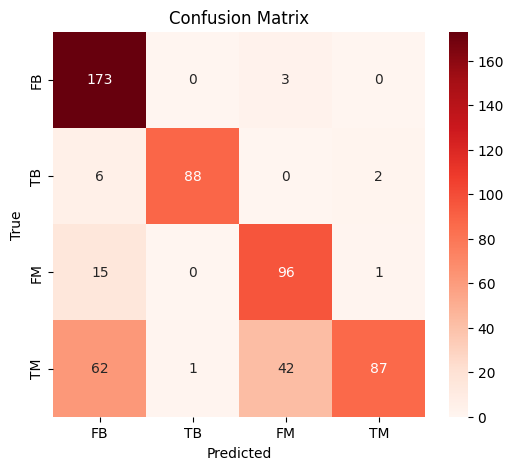

Accuracy: 0.77


In [87]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_predictions(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            X, y_true = batch

            X = X.to(device)
            y_true = y_true.to(device)

            logits = model(X)
            _, predicted_labels = torch.max(logits, 1)

            all_preds.extend(predicted_labels.cpu().numpy())
            all_labels.extend(y_true.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

classes = list(range(4))
decoded_classes = [decode_label(c) for c in classes]
y_true, y_pred = get_predictions(model, test_loader, device=DEVICE)

#plot matrix
plot_confusion_matrix(y_true, y_pred, decoded_classes)

accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.2f}')

<h4>Precision, Recall, F1-Score, and Accuracy</h4>
<p>Calculate metrics for each class and overall.</p>

In [83]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

def matrix_calculation(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)

    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)

    metrics_data = {
        "Class": classes,
        "Precision": precision.round(4),
        "Recall": recall.round(4),
        "F1-Score": f1.round(4)
    }

    df = pd.DataFrame(metrics_data)
    df.loc['Overall'] = {
        "Class": "Overall",
        "Precision": precision_score(y_true, y_pred, average='macro', zero_division=0).round(4),
        "Recall": recall_score(y_true, y_pred, average='macro', zero_division=0).round(4),
        "F1-Score": f1_score(y_true, y_pred, average='macro', zero_division=0).round(4)
    }
    return df, accuracy

classes = list(range(4))
decoded_classes = [decode_label(c) for c in classes]
y_true, y_pred = get_predictions(model, test_loader, device=DEVICE)
metrics_table, overall_accuracy = matrix_calculation(y_true, y_pred, decoded_classes)

print("Metrics Table:")
print(metrics_table.to_string(index=False))
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

Metrics Table:
  Class  Precision  Recall  F1-Score
     FB     0.6758  0.9830    0.8009
     TB     0.9888  0.9167    0.9514
     FM     0.6809  0.8571    0.7589
     TM     0.9667  0.4531    0.6170
Overall     0.8280  0.8025    0.7820

Overall Accuracy: 0.7708
